In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

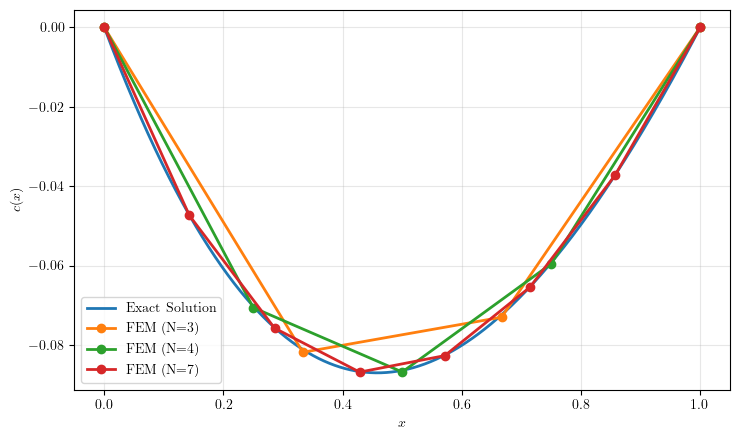

In [2]:
def f(x):
    return np.exp(-x**2)

def solve_tridiagonal(lower, diag, upper, rhs):
    """
    Thomas algorithm for tridiagonal systems.
    lower, diag, upper are 1D arrays with lengths n-1, n, n-1.
    """
    n = diag.size
    a = lower.astype(float).copy()
    b = diag.astype(float).copy()
    c = upper.astype(float).copy()
    d = rhs.astype(float).copy()

    # forward elimination
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    # back substitution
    x = np.empty(n)
    x[-1] = d[-1] / b[-1]
    for i in range(n - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
    return x

def fem_solve_1d(N):
    """
    FEM for c'' - c = exp(-x^2) on [0,1], c(0)=c(1)=0,
    using P1 (tent) basis on a uniform mesh with N elements.
    Returns nodes x (N+1,) and nodal values c (N+1,).
    """
    x = np.linspace(0.0, 1.0, N + 1)
    h = x[1] - x[0]
    n = N - 1  # interior unknowns: 1..N-1

    if n <= 0:
        return x, np.zeros_like(x)

    # assemble A = K + M (SPD form), with RHS = -b
    diag = (2.0 / h) + (2.0 * h / 3.0)
    off  = (-1.0 / h) + (h / 6.0)

    main = np.full(n, diag)
    low  = np.full(n - 1, off)
    up   = np.full(n - 1, off)

    # assemble load b_i = ∫ f(x) Phi_i(x) dx via 2-pt Gauss per element
    b = np.zeros(n)

    # Gauss points/weights on [-1,1]
    gp = np.array([-1.0 / np.sqrt(3.0),  1.0 / np.sqrt(3.0)])
    gw = np.array([1.0, 1.0])

    for e in range(N):
        xa, xb = x[e], x[e + 1]
        J = (xb - xa) / 2.0
        xm = (xa + xb) / 2.0

        # quadrature points in physical element
        xq = xm + J * gp
        fq = f(xq)

        # local P1 basis on [xa, xb]
        phi_left  = (xb - xq) / h
        phi_right = (xq - xa) / h

        be_left  = np.sum(gw * fq * phi_left)  * J
        be_right = np.sum(gw * fq * phi_right) * J

        # add to global load vector for interior nodes only
        left_node = e
        right_node = e + 1

        if 1 <= left_node <= N - 1:
            b[left_node - 1] += be_left
        if 1 <= right_node <= N - 1:
            b[right_node - 1] += be_right

    rhs = -b  # because (K+M)c = -b

    c_int = solve_tridiagonal(low, main, up, rhs)

    c = np.zeros(N + 1)
    c[1:N] = c_int
    return x, c

Ns = [3, 4, 7]

N_ref = 10000
x_ref, c_ref = fem_solve_1d(N_ref)

x_plot = np.linspace(0, 1, 2001)
c_ref_plot = np.interp(x_plot, x_ref, c_ref)

plt.figure(figsize=(7.5, 4.5))
plt.plot(x_plot, c_ref_plot, linewidth=2.0, label=f"Exact Solution")  # shhh.....

for N in Ns:
    xN, cN = fem_solve_1d(N)
    plt.plot(xN, cN, marker="o", linewidth=2.0, label=f"FEM (N={N})")

plt.xlabel("$x$")
plt.ylabel("$c(x)$")
# plt.title(r"FEM for $c'' - c = e^{-x^2}$ with $c(0)=c(1)=0$ (P1 tent basis)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("../../../figs/ode/fem_convergence.pdf", bbox_inches="tight", transparent=True)
plt.show()

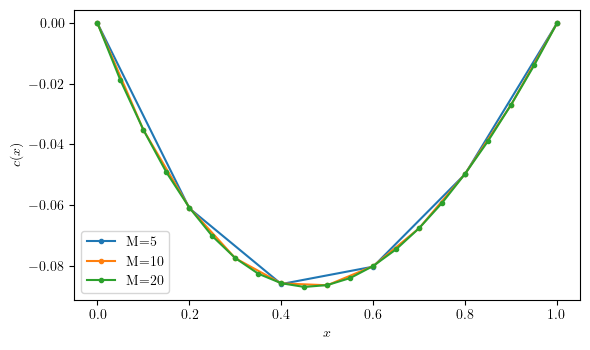

In [3]:
def rhs_cell_average_exp_minus_x2(xi, dx):
    """
    (1/dx) ∫_{xi-dx/2}^{xi+dx/2} exp(-x^2) dx
    via 2-point Gauss-Legendre (exact for cubics; very accurate here).
    For averages over a cell, this simplifies nicely.
    """
    d = dx / (2.0 * np.sqrt(3.0))
    return 0.5 * (np.exp(-(xi - d) ** 2) + np.exp(-(xi + d) ** 2))


def thomas_tridiag(a, b, c, d):
    """
    Solve tridiagonal system with subdiag a, diag b, superdiag c, RHS d.
    All are 1D arrays with lengths: len(b)=n, len(a)=len(c)=n-1.
    """
    n = len(b)
    cp = np.empty(n - 1, dtype=float)
    dp = np.empty(n, dtype=float)

    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, n - 1):
        denom = b[i] - a[i - 1] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i - 1] * dp[i - 1]) / denom
    denom = b[n - 1] - a[n - 2] * cp[n - 2]
    dp[n - 1] = (d[n - 1] - a[n - 2] * dp[n - 2]) / denom

    x = np.empty(n, dtype=float)
    x[-1] = dp[-1]
    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]
    return x


def fvm_solve(M, reaction_sign=-1.0):
    """
    Solve c'' - c = exp(-x^2), c(0)=c(1)=0 on a uniform grid with M intervals (M+1 nodes).

    reaction_sign:
      -1.0 matches the PDE as written (c'' - c = f)
      +1.0 would match the sign in your final displayed stencil if you keep it as "+ 1/8(...)".
    """
    dx = 1.0 / M
    n = M - 1  # unknowns c_1..c_{M-1}

    # Tridiagonal coefficients from:
    # (1/dx^2)(c_{i+1}-2c_i+c_{i-1})  +  reaction_sign*(1/8)(c_{i+1}+6c_i+c_{i-1})  = RHS_i
    off = (1.0 / dx**2) + reaction_sign * (1.0 / 8.0)
    diag = (-2.0 / dx**2) + reaction_sign * (6.0 / 8.0)

    a = np.full(n - 1, off)   # subdiag
    b = np.full(n, diag)      # diag
    c = np.full(n - 1, off)   # superdiag

    # RHS: control-volume averages at interior nodes x_i = i*dx
    i = np.arange(1, M)
    x_i = i * dx
    rhs = rhs_cell_average_exp_minus_x2(x_i, dx)

    c_int = thomas_tridiag(a, b, c, rhs)

    # pad boundaries
    x_nodes = np.linspace(0.0, 1.0, M + 1)
    c_nodes = np.zeros(M + 1)
    c_nodes[1:M] = c_int
    return x_nodes, c_nodes


plt.figure(figsize=(6.0, 3.6))

reaction_sign=-1.0

for M in [5, 10,20]:
    x, c = fvm_solve(M, reaction_sign=reaction_sign)
    plt.plot(x, c, marker="o", markersize=3, linewidth=1.5, label=f"M={M}")
plt.xlabel(r"$x$")
plt.ylabel(r"$c(x)$")
plt.legend()
plt.tight_layout()
plt.savefig("../../../figs/ode/fvm_convergence.pdf")
plt.show()

